# 1.&nbsp; Image Classification with Transfer Learning

The subject of image classification has been studied in depth, and many famous models, like the AlexNet and VGG models we saw earlier, are readily available through PyTorch. However, these models have been trained with the ImageNet dataset. Although ImageNet contains 1,000 different image classes, it may not contain the classes that you need to solve your image classification problem.

In this case, you can apply transfer learning, a process in which we fine-tune pretrained models with a much smaller dataset of new images. For our next example, we will train a model to classify images of bees and ants—classes not contained in ImageNet. Bees and ants look very similar and can be difficult to distinguish.

To train our new classifier, we will fine-tune another famous model, called ResNet18, by loading the pretrained model and training it with 120 new training images of bees and ants— a much smaller set compared to the millions of images in ImageNet.

##  1.1&nbsp; Data Preprocessing

Let’s begin by loading our data, defining our transforms, and
configuring our dataloaders for batch sampling. As we did earlier,
we’ll leverage functions from the Torchvision library for
creating the datasets, loading the data, and applying the data
transforms.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models
from torchvision import transforms

Then we’ll download the data that we’ll use for training and
validation:

In [ ]:
from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile
zipurl = 'https://pytorch.tips/bee-zip'
with urlopen(zipurl) as zipresp:
  with ZipFile(BytesIO(zipresp.read())) as zfile:
    zfile.extractall('./data')

Here, we use the io, urlib, and zipfile libraries to download
and unzip a file to our local filesystem. After running the
previous code, you should have your training and validation
images in your local data/ folder. They are located in
data/hymenoptera_data/train and data/hymenoptera_data/val,
respectively

Next let’s define our transforms, load the data, and configure
our batch samplers.

In [ ]:
#Data Augmentasi dan Data Transformasi
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.5, 0.5,0.5],
        [0.5, 0.5,0.5])])
val_transforms = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225])])

Notice that we randomly resize, crop, and flip images for training
but not for validation. The “magic” numbers used in the
Normalize transforms are precomputed values for the means
and standard deviations.

In [ ]:
train_dataset = datasets.ImageFolder(
    root='data/hymenoptera_data/train',
    transform=train_transforms)

val_dataset = datasets.ImageFolder(
    root='data/hymenoptera_data/val',
    transform=val_transforms)

In the previous code we used the ImageFolder dataset to pull
images from our data folders and set the transforms to the ones
we defined earlier. Next, we define our dataloaders for batch
iteration:

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    shuffle=True,
    num_workers=0)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
    shuffle=False,
    num_workers=0)

##  1.2&nbsp; Model Design

For this example we’ll use a ResNet18 model that has been pretrained
with ImageNet data. However, ResNet18 is designed to
detect 1,000 classes, and in our case, we only need 2 classes—
bees and ants. We can modify the final layer to detect 2 classes
instead of 1,000 as shown in the following code:

In [ ]:
model = models.resnet18(pretrained=True)
print(model.fc)
# out:
# Linear(in_features=512, out_features=1000, bias=True)
num_ftrs = model.fc.in_features
#proses fully connected
model.fc = nn.Linear(num_ftrs, 2)
print(model.fc)
# out:
# Linear(in_features=512, out_features=2, bias=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Linear(in_features=512, out_features=1000, bias=True)
Linear(in_features=512, out_features=2, bias=True)


We first load a pretrained ResNet18 model using the function
torchvision.models.resnet18(). Next, we read the number of
features before the final layer with model.fc.in_features. Then
we change the final layer by directly setting model.fc to a fully
connected layer with two outputs.

We are going to use the pretrained model as a starting point
and fine-tune its parameters with new data. Since we replaced
the final linear layer, its parameters are now randomly
initialized.

Now we have a ResNet18 model with all weights pretrained
with ImageNet images except for the last layer. Next, we need
to train our model with images of bees and ants.

##  1.3&nbsp; Training and Validation

Before we fine-tune our model, let’s configure our training with
the following code:

In [ ]:
from torch.optim.lr_scheduler import StepLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") #kita akan menggunakan GPU
model = model.to(device)#Move the model to a GPU if available
criterion = nn.CrossEntropyLoss() # Define our loss function
optimizer = optim.SGD(model.parameters(),lr=0.001,momentum =0.9) #Define our optimizer algorithm
exp_lr_scheduler = StepLR(optimizer,step_size=7,gamma=0.1)

The code should look familiar, with the exception of the learning
rate scheduler. Here we will use a scheduler from PyTorch
to adjust the learning rate of our SGD optimizer after several
epochs. Using a learning rate scheduler will help our NN adjust
its weights more precisely as training goes on.



In [ ]:
num_epochs =5

for epochs in range(num_epochs):
  print("Epoch : ", epochs)
  model.train() #training loop
  running_loss = 0.0
  running_corrects = 0
  for inputs, labels in train_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()
    outputs = model(inputs)
    _, preds = torch.max(outputs,1)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()/inputs.size(0)
    running_corrects += torch.sum(preds == labels.data)/inputs.size(0)

    exp_lr_scheduler.step() #schedule the learning rate for next the epoch of training
    train_epoch_loss = running_loss / len(train_loader)
    train_epoch_acc = running_corrects / len(train_loader)

    model.eval() #validation loop
    
    running_loss = 0.0
    running_corrects = 0
    
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
      outputs = model(inputs)
      _, preds = torch.max(outputs,1)
      loss = criterion(outputs, labels)
      running_loss += loss.item()/inputs.size(0)
      running_corrects +=torch.sum(preds == labels.data)/inputs.size(0)
    
    epoch_loss = running_loss / len(val_loader)
    epoch_acc = running_corrects.double() / len(val_loader)
  print("Train: Loss: {:.4f} Acc: {:.4f}"
    " Val: Loss: {:.4f}"
    " Acc: {:.4f}".format(train_epoch_loss,train_epoch_acc,epoch_loss,epoch_acc))

Epoch :  0
Train: Loss: 0.0265 Acc: 0.5651 Val: Loss: 0.0318 Acc: 0.8354
Epoch :  1
Train: Loss: 0.0325 Acc: 0.5495 Val: Loss: 0.0318 Acc: 0.8292
Epoch :  2
Train: Loss: 0.0282 Acc: 0.5573 Val: Loss: 0.0322 Acc: 0.8167
Epoch :  3
Train: Loss: 0.0272 Acc: 0.5573 Val: Loss: 0.0328 Acc: 0.8167
Epoch :  4
Train: Loss: 0.0279 Acc: 0.5612 Val: Loss: 0.0332 Acc: 0.8229


##  1.4&nbsp; Testing and Development

Let’s test our model and deploy it by saving the model to a file.
To test our model, we’ll display a batch of images and show
how our model classified them,

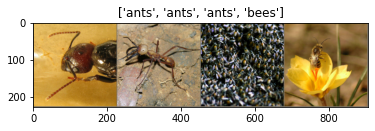

In [ ]:
import matplotlib.pyplot as plt
def imshow(inp, title=None): #Define a new function to plot images from our tensor images.
  inp = inp.numpy().transpose((1, 2, 0)) #Switch from C × H × W to H × W × C image formats for plotting.
  mean = np.array([0.485, 0.456, 0.406]) 
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean #Undo the normalization we do during transforms so we can properly view images.
  inp = np.clip(inp, 0, 1) 
  plt.imshow(inp)
  if title is not None:
    plt.title(title)


inputs, classes = next(iter(val_loader)) #Grab a batch of images from our validation dataset.
out = torchvision.utils.make_grid(inputs) 
class_names = val_dataset.classes

outputs = model(inputs.to(device)) #Perform classification using our fine-tuned ResNet18.
_, preds = torch.max(outputs,1) #Take the “winning” class.

imshow(out, title=[class_names[x] for x in preds]) #Display the input images and their predicted classes